In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np 
import glob, os, subprocess
from dateutil import parser

import matplotlib.pyplot as plt
import matplotlib
import datacube
import sys, shutil
sys.path.append("..")

from SRC import *

%matplotlib inline
matplotlib.rcParams.update({'font.size': 11})
matplotlib.rcParams['savefig.dpi'] = 300


indir = '../MULLION/14APR20/flame_data/2pnt1m_lines/'
outdir = '../PNGS/MULLION/14APR20/'
calfile = '../CALIBRATION/FLAME_calibration_GA_ORIGINAL/Analysed/Analysed/RadCalCoeff_GT8.csv'
TelemetryFile = '../MULLION/14APR20/log_files/Apr-14th-2020-11-47AM-Flight-Airdata.csv'

field_data = ['MUL', '20MAR20', '', 'Sentinel2a', 'GA 10inch Panel 99aa03-0319-1952']

fignum=1

In [2]:
TeleDat = pd.read_csv(TelemetryFile)

In [3]:
TeleDat.drop(['height_above_ground_at_drone_location(meters)', 
              'ground_elevation_at_drone_location(meters)',
              'satellites',
              'gpslevel',
              'voltage(v)',
              'max_altitude(meters)',
              'max_ascent(meters)',
              'max_speed(m/s)',
              'max_distance(meters)',
              ' xSpeed(m/s)',
              ' ySpeed(m/s)',
              ' zSpeed(m/s)',
              'isPhoto',
              'isVideo',
              'rc_elevator',
              'rc_aileron',
              'rc_throttle',
              'rc_rudder',
              'battery_percent',
              'voltageCell1',
              'voltageCell2',
              'voltageCell3',
              'voltageCell4',
              'voltageCell5',
              'voltageCell6',
              'current(A)',
              'battery_temperature(c)',
              'altitude(meters)',
              'ascent(meters)',
              'flycStateRaw',
              'flycState'], axis=1, inplace=True)

In [4]:
TeleDat.rename(columns={'time(millisecond)': 'time_ms',
                        'datetime(utc)': 'datetime',
                        'height_above_takeoff(meters)': 'height_local',
                        'altitude_above_seaLevel(meters)': 'height_sea',
                        'distance(meters)': 'distance(m)',
                        ' compass_heading(degrees)': 'compass_heading',
                        ' pitch(degrees)': 'pitch',
                        ' roll(degrees)': 'roll',
                        'gimbal_heading(degrees)': 'gimbal_heading',
                        'gimbal_pitch(degrees)': 'gimbal_pitch',
                        'message': 'comment'
                       }, inplace=True
              )

In [5]:
TeleDat['datetime'] = [parser.parse(TeleDat.datetime[i]) for i in range(len(TeleDat.datetime))]

In [6]:
TeleDat = TeleDat[TeleDat['datetime'] > datetime(2020,4,14,1,53,0)]

In [7]:
TeleDat['date_saved'] = [TeleDat.datetime.iloc[0] + timedelta(milliseconds=int(TeleDat.time_ms.iloc[i])) - timedelta(milliseconds=199900) for i in range(len(TeleDat.datetime))]

In [8]:
alldata = LoadData.load_from_dir(indir, calfile)

In [9]:
alldata['radiance'] = alldata.DN*alldata.CalData/alldata.IntTime
alldata['radiance'] = alldata['radiance']/10000
alldata['Line']=1
#alldata['Latitude'] = -35.123277
#alldata['Longitude'] = 148.862692

In [10]:
#
# Bin spectra into integer wavelength bins, assuming that the input data
# has 0.3nm channels.
#
def wavelength_bin(alldata):
    # Create avgdata DataFrame, based on alldata input DataFrame
    # Reset index so that Wavelength is not the index.
    avgdata = alldata.copy()
    avgdata.reset_index(inplace=True)
    
    ### Make a mean of three rows for each of DN, Calibration, Radiance
    ###avgdata['DNmean'] = avgdata.DN.rolling(3, center=True).mean()
    ###avgdata['Calmean'] = avgdata.CalData.rolling(3, center=True).mean()
    ###avgdata['Radmean'] = avgdata.radiance.rolling(3, center=True).mean()
    
    # Remove first and last wavelengths which have NaNs in them.
    avgdata = avgdata[avgdata.Wavelength != 349.176]
    avgdata = avgdata[avgdata.Wavelength != 910.925]
    
    # Create empty output DataFrame
    outputDF = pd.DataFrame()
    ttmm = pd.DataFrame()
    
    # Loop through each spectrum in the dataframe
    for j in avgdata.SpecNum.unique():
        tempdata = avgdata[avgdata.SpecNum==j].groupby(pd.cut(avgdata[avgdata.SpecNum==j]['Wavelength'], np.arange(349.5,910.5,1.0))).mean()
        tempdata['date_saved'] = avgdata[avgdata.SpecNum==j].date_saved.values[0]
        tempdata['filename'] = avgdata[avgdata.SpecNum==j].filename.values[0]
        
        tempdata.index.rename('plop', inplace=True)
        tempdata.reset_index(inplace=True)
        tempdata.drop(columns='plop', inplace=True)
        tempdata.Wavelength = tempdata.Wavelength.round(0).astype(int)        
        
        # When finished making an entire spectrum, add it to the output DataFrame
        # and print how many have been done.
        if outputDF.empty:
            outputDF = tempdata.copy()
        
        else:
            if j % 100 == 0:
                ttmm = pd.concat([ttmm, tempdata])
                outputDF = pd.concat([outputDF, ttmm])
                ttmm = pd.DataFrame()
            
            elif j == len(avgdata.SpecNum.unique())-1:
                ttmm = pd.concat([ttmm, tempdata])
                outputDF = pd.concat([outputDF, ttmm])
            
            elif ttmm.empty:
                ttmm = tempdata.copy()
            
            else:
                ttmm = pd.concat([ttmm, tempdata])
                
            
        print('Completed ', j+1, '/', len(avgdata.SpecNum.unique()), ' spectra', end='\r', flush=True)

    # output final DataFrame
    return outputDF

avgdata = wavelength_bin(alldata)

In [11]:
alldat = avgdata.reset_index()

In [12]:
plop = pd.merge_asof(alldat, TeleDat, on='date_saved')

In [13]:
#plop = plop.set_index('Wavelength')

In [14]:
plop = plop[plop.latitude < 0]

In [15]:
plop

,index,Wavelength,DN,CalData,IntTime,SpecNum,radiance,Line,date_saved,filename,...,height_local,height_sea,speed(m/s),distance(m),compass_heading,pitch,roll,gimbal_heading,gimbal_pitch,comment
532000,0,350,62.919463,0.000016,0.00228,950,0.000043,1,2020-04-14 01:53:22.395,10m_lines_Subt4_01-53-22-395.txt,...,0.0,578.860779,0.001175,0.691561,84.6,-0.3,-0.9,0.016368,-0.027229,NaN
532001,1,351,60.147920,0.000015,0.00228,950,0.000041,1,2020-04-14 01:53:22.395,10m_lines_Subt4_01-53-22-395.txt,...,0.0,578.860779,0.001175,0.691561,84.6,-0.3,-0.9,0.016368,-0.027229,NaN
532002,2,352,66.329428,0.000017,0.00228,950,0.000049,1,2020-04-14 01:53:22.395,10m_lines_Subt4_01-53-22-395.txt,...,0.0,578.860779,0.001175,0.691561,84.6,-0.3,-0.9,0.016368,-0.027229,NaN
532003,3,353,70.169043,0.000017,0.00228,950,0.000052,1,2020-04-14 01:53:22.395,10m_lines_Subt4_01-53-22-395.txt,...,0.0,578.860779,0.001175,0.691561,84.6,-0.3,-0.9,0.016368,-0.027229,NaN
532004,4,354,80.268835,0.000017,0.00228,950,0.000060,1,2020-04-14 01:53:22.395,10m_lines_Subt4_01-53-22-395.txt,...,0.0,578.860779,0.001175,0.691561,84.6,-0.3,-0.9,0.016368,-0.027229,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041035,555,905,38.983894,0.000080,0.00228,1858,0.000136,1,2020-04-14 02:08:52.342,10m_lines_Subt4_02-08-52-342.txt,...,0.7,579.560779,0.030460,1.288050,78.0,-0.4,-1.3,0.069657,-0.064871,NaN
1041036,556,906,40.540618,0.000081,0.00228,1858,0.000144,1,2020-04-14 02:08:52.342,10m_lines_Subt4_02-08-52-342.txt,...,0.7,579.560779,0.030460,1.288050,78.0,-0.4,-1.3,0.069657,-0.064871,NaN
1041037,557,907,35.503833,0.000084,0.00228,1858,0.000131,1,2020-04-14 02:08:52.342,10m_lines_Subt4_02-08-52-342.txt,...,0.7,579.560779,0.030460,1.288050,78.0,-0.4,-1.3,0.069657,-0.064871,NaN
1041038,558,908,33.266832,0.000083,0.00228,1858,0.000121,1,2020-04-14 02:08:52.342,10m_lines_Subt4_02-08-52-342.txt,...,0.7,579.560779,0.030460,1.288050,78.0,-0.4,-1.3,0.069657,-0.064871,NaN


In [16]:
panel_names, all_panels, all_grounds = ExtractPanelsGrounds.extract_panels_grounds(plop)

In [17]:
all_panel_spec = MakeSpecDF.make_spec_df(all_panels)

TypeError: no numeric data to plot

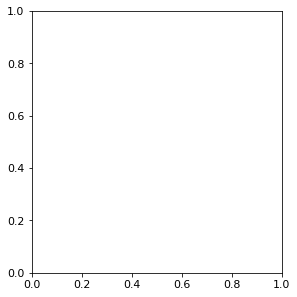

In [18]:
FIG_PanelRadiances.FIG_panel_radiances(all_panel_spec, outdir, field_data, fignum)

fignum += 1

In [22]:
all_grounds_spec = MakeSpecDF.make_spec_df(all_grounds)

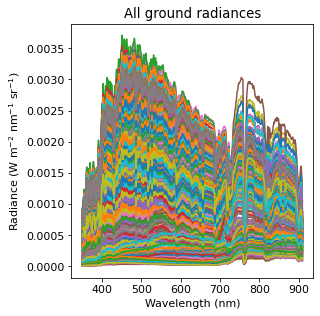

In [23]:
FIG_GroundSpectra.FIG_ground_spectra(all_grounds_spec, outdir, field_data, fignum)
fignum +=1

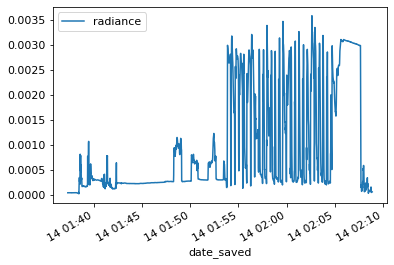

In [24]:
avgdata[abs(avgdata.Wavelength-450)<0.185].plot('date_saved', 'radiance')

In [25]:
allASDdata = pd.read_pickle('../MULLION/20MAR20/ASD/alldat.pick')

In [26]:
#avgdata.radiance = avgdata.radiance*52

(0.0, 0.025)

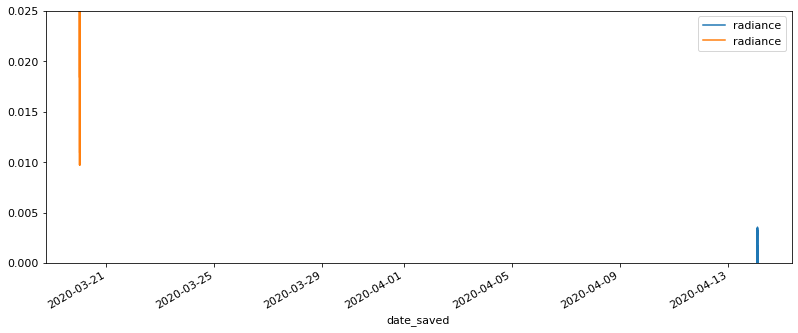

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 5.5))
plt.tight_layout(pad=5.5, w_pad=1.0, h_pad=1.0)
avgdata[abs(avgdata.Wavelength-450)<0.185].plot('date_saved', 'radiance', ax=axes)
allASDdata[allASDdata.Wavelength==450].plot('date_saved', 'radiance', ax=axes)
axes.set_ylim(0.000,0.025)
#axes.set_xlim(datetime(2020,3,20), datetime(2020,3,20,1))

In [40]:
avgdata[avgdata.Wavelength==450]

,Wavelength,DN,CalData,IntTime,SpecNum,radiance,Line,date_saved,filename
100,450,125.930074,0.000008,0.00228,0,0.000046,1,2020-04-14 01:37:17.230,10m_lines_Subt4_01-37-17-230.txt
100,450,126.966377,0.000008,0.00228,1,0.000046,1,2020-04-14 01:37:18.242,10m_lines_Subt4_01-37-18-242.txt
100,450,127.251928,0.000008,0.00228,2,0.000047,1,2020-04-14 01:37:19.254,10m_lines_Subt4_01-37-19-254.txt
100,450,128.731118,0.000008,0.00228,3,0.000047,1,2020-04-14 01:37:20.270,10m_lines_Subt4_01-37-20-270.txt
100,450,126.761386,0.000008,0.00228,4,0.000046,1,2020-04-14 01:37:21.289,10m_lines_Subt4_01-37-21-289.txt
...,...,...,...,...,...,...,...,...,...
100,450,153.830068,0.000008,0.00228,1854,0.000056,1,2020-04-14 02:08:48.251,10m_lines_Subt4_02-08-48-251.txt
100,450,155.015765,0.000008,0.00228,1855,0.000057,1,2020-04-14 02:08:49.271,10m_lines_Subt4_02-08-49-271.txt
100,450,160.845157,0.000008,0.00228,1856,0.000059,1,2020-04-14 02:08:50.291,10m_lines_Subt4_02-08-50-291.txt
100,450,171.391618,0.000008,0.00228,1857,0.000063,1,2020-04-14 02:08:51.318,10m_lines_Subt4_02-08-51-318.txt


In [ ]:
all_panels.drop('Solar_angle', axis=1, inplace=True)

In [ ]:
avgdata.to_pickle('avgdata.pick')

In [ ]:
all_panels, all_grounds = SolarAngle.solar_angle(all_panels, all_grounds, field_data)

In [ ]:
all_panels = PanelBRF.Panel_BRF(all_panels, field_data)

In [ ]:
gpta, adta = CreateTimeRelativeDF.create_time_relative_dfs(all_panels, all_grounds)

In [ ]:
FIG_AllTimelines.FIG_all_timelines(gpta, adta, outdir, field_data, fignum)
fignum += 1

In [ ]:
all_panel_mean = all_panel_spec.mean(axis=1)

gpta = FIG_NormalisedPanelsTimeline.normalise_spectra(all_panel_mean, all_panel_spec, gpta, field_data)

FIG_NormalisedPanelsTimeline.FIG_normalised_panels_timeline(gpta, outdir, field_data, fignum)

fignum += 1

In [ ]:
gpta['Latitude'] = -35.123277
gpta['Longitude'] = 148.862692
adta['Latitude'] = -35.123277
adta['Longitude'] = 148.862692

In [ ]:
slope, intercept, coszenith = FIG_InsolationFit.FIG_insolation_fit(gpta, outdir, field_data, fignum)
fignum += 1